In [35]:
# Python Chess Analysis Code v 05
# Dr. Matthew P. Tedesco July 2017
# The objective of this program is to generate an in depth game analysis
# In addition to traditional engine evaluations this program also provides metrics related to:
# 1) Material: Delta between sum of piece values for white and black
# 2) Development: Delta between the number of pieces (not pawns) no longer on their starting squares 
# 3) Mobility: Delta between the number of total legal moves
# 4) Control: Delta between the number of squares controlled by both sides.  This is associated with SPACE.
# 5) Tension (pressure): Delta between the number of attacking pieces for both sides
# 6) King safety: A weighted king tropism using the simple Chebyshev distance as the max of the 
#                 distance of the ranks or the files weighted based on piece values
#
# The program identifies innaccuracies, mistakes and blunders based on the engine evaluation cp deltas and also 
# indicates which side played a higher quality game overall based on the relative number of inaccuracies, mistakes, 
# and blunders.
#
# This early code assumes the PGN contains one game
#
# NOTE: This code relies on the python-chess library. You need to install the python-chess package.

import chess
import chess.uci as uci
import chess.pgn as pgn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns

# KEY VARIABLES

path = "D:/Dropbox/Python Projects/Chess Projects/" # set your working folder
pgnfile = "test.pgn" # your pgn file
enginepath = "D:/Dropbox/Python Projects/Chess Projects/" # path to your engine
enginefile = "stockfish_8_x64_popcnt" # engine file name
totaltime = 1 # total desired engine analysis time in minutes per game

# Thresholds in centipawns defining inaccuracy, mistake and blunder
inaccuracy = 30 
mistake = 90 
blunder = 200

# Piece Values in centipawns
pawn = 100
knight = 300
bishop = 300
rook = 500
queen = 900
king = 2500

# Open the pgn file

with io.open(path+pgnfile,encoding="utf-8-sig)") as pgnin:
    game = chess.pgn.read_game(pgnin)

            
      


In [36]:
# start performing the analysis

board = chess.Board()

#establish a dataframe to store my evaluations
gamedata = pd.DataFrame (
    columns =['Ply', 'Side' ,'Move', 'CP','Mate', 'CP Delta','Suggested','Depth', 'Material', \
              'Development', 'Mobility', 'Control', 'Tension', 'Safety'])

# loop through the game to count total plies (used to set analysis time)
node = game
plytotal = 1
while not node.is_end():
    next_node = node.variations[0]
    plytotal += 1 
    node = next_node

time = totaltime*60000/plytotal # sets associated analysis time per ply in milliseconds

# start chess engine
engine = chess.uci.popen_engine(enginepath+enginefile)
engine.uci()
info_handler = chess.uci.InfoHandler()
engine.info_handlers.append(info_handler)


# loop through the game ply by ply and populate the dataframe with evaluation data
node = game
cap = 30 # initial advantage for white is generally accepted as 30 centipawns
ply = 0
matedist = "N/A"

while not node.is_end():
    next_node = node.variations[0]
    move = node.board().san(next_node.move)
    if board.turn:
        side = "W"
    else:
        side = "B"
    
            
    capprior = cap
    
    # Do an engine evaluation of the position
    # can either set depth or movetime - I am setting movetime for predictable analysis times      
    engine.position(board) 
    bestmove, pondermove = engine.go(movetime = time) 
    cap=info_handler.info["score"][1].cp
    mate = info_handler.info["score"][1].mate
    if mate is not None:
        matedist = mate
        cap = mate/abs(mate)*king # set a very high cap if mate is on the board
    else:
        matedist = "N/A"
    depth=info_handler.info["depth"]
    suggested = board.san(bestmove)
    if side == "B":
        cap = - cap
    
    cpdelta = cap-capprior
    
    board.push(next_node.move) # calculate values based on the new position on the board
    
    # Material
    whitepawns = len(board.pieces(1,1))
    whiteknights = len(board.pieces(2,1))
    whitebishops = len(board.pieces(3,1))
    whiterooks = len(board.pieces(4,1))
    whitequeens = len(board.pieces(5,1))
    whiteking = len(board.pieces(6,1))
    whitematerial = pawn*whitepawns + knight*whiteknights + bishop*whitebishops + \
                    rook*whiterooks + queen*whitequeens +king*whiteking
    blackpawns = len(board.pieces(1,0))
    blackknights = len(board.pieces(2,0))
    blackbishops = len(board.pieces(3,0))
    blackrooks = len(board.pieces(4,0))
    blackqueens = len(board.pieces(5,0))
    blackking = len(board.pieces(6,0))
    blackmaterial = pawn*blackpawns + knight*blackknights + bishop*blackbishops + \
                    rook*blackrooks + queen*blackqueens +king*blackking
    material = whitematerial - blackmaterial
    
    # Development
    # Assess number of pieces no longer on starting squares for both sides
    whitedevelopment = 8
    blackdevelopment = 8
    if board.piece_at(chess.square(0,0)):
        if board.piece_at(chess.square(0,0)).symbol() == "R":
            whitedevelopment -= 1
    if board.piece_at(chess.square(1,0)):
        if board.piece_at(chess.square(1,0)).symbol() == "N":
            whitedevelopment -= 1
    if board.piece_at(chess.square(2,0)):
        if board.piece_at(chess.square(2,0)).symbol() == "B":
            whitedevelopment -= 1
    if board.piece_at(chess.square(3,0)):
        if board.piece_at(chess.square(3,0)).symbol() == "Q":
            whitedevelopment -= 1
    if board.piece_at(chess.square(4,0)):
        if board.piece_at(chess.square(4,0)).symbol() == "K":
            whitedevelopment -= 1
    if board.piece_at(chess.square(5,0)):
        if board.piece_at(chess.square(5,0)).symbol() == "B":
            whitedevelopment -= 1
    if board.piece_at(chess.square(6,0)):
        if board.piece_at(chess.square(6,0)).symbol() == "N":
            whitedevelopment -= 1
    if board.piece_at(chess.square(7,0)):
        if board.piece_at(chess.square(7,0)).symbol() == "R":
            whitedevelopment -= 1
    if board.piece_at(chess.square(0,7)):
        if board.piece_at(chess.square(0,7)).symbol() == "r":
            blackdevelopment -= 1
    if board.piece_at(chess.square(1,7)):
        if board.piece_at(chess.square(1,7)).symbol() == "n":
            blackdevelopment -= 1
    if board.piece_at(chess.square(2,7)):
        if board.piece_at(chess.square(2,7)).symbol() == "b":
            blackdevelopment -= 1
    if board.piece_at(chess.square(3,7)):
        if board.piece_at(chess.square(3,7)).symbol() == "q":
            blackdevelopment -= 1
    if board.piece_at(chess.square(4,7)):
        if board.piece_at(chess.square(4,7)).symbol() == "k":
            blackdevelopment -= 1
    if board.piece_at(chess.square(5,7)):
        if board.piece_at(chess.square(5,7)).symbol() == "b":
            blackdevelopment -= 1
    if board.piece_at(chess.square(6,7)):
        if board.piece_at(chess.square(6,7)).symbol() == "n":
            blackdevelopment -= 1
    if board.piece_at(chess.square(7,7)):
        if board.piece_at(chess.square(7,7)).symbol() == "r":
            blackdevelopment -= 1
    development = whitedevelopment - blackdevelopment 
    
    # Mobility
    # Calculate all legal moves for white and black
    mobility1 = len(board.legal_moves)
    # Change side to move by pushing a null move and calculate all moves for opponent
    board.push(chess.Move.null())
    mobility2 = len(board.legal_moves)
    # Take back the null move to reset the board back to the position
    board.pop()
    if side == "W":
        mobility = mobility2 - mobility1
    else:
        mobility = mobility1 - mobility2
        
    # Control
    # Control is closely associated with "Space"
    # We will calculate for every square the delta of white attackers to black attackers and sum the deltas
    whitecontrol = 0
    blackcontrol= 0
    for spacesquare in range (64):
        whitecontrol += len(board.attackers(chess.WHITE, spacesquare))
        blackcontrol += len(board.attackers(chess.BLACK, spacesquare))
    control = whitecontrol - blackcontrol
        
    # Tension (or Pressure)
    # very simplistic right now - just a delta of # of attacked pieces for black vs. white
    # when a piece is attacked by the opposing color
        
    spacesquare = 0
    tensionwhite = 0
    tensionblack = 0
    tension = 0
    for spacesquare in range(64):
        if board.piece_at(spacesquare):
            if board.piece_at(spacesquare).symbol() == "K":
                whitekingsquare = spacesquare # used later for king safety
            if board.piece_at(spacesquare).symbol() == "k":
                blackkingsquare = spacesquare # used later for king safety
            if board.piece_at(spacesquare).color == chess.BLACK:
                if board.is_attacked_by(chess.WHITE, spacesquare):
                    tensionwhite += 1
            if board.piece_at(spacesquare).color == chess.WHITE:
                if board.is_attacked_by(chess.BLACK, spacesquare):
                    tensionblack +=1
    tension = tensionwhite - tensionblack
    
    # King Safety
    # This could get very complicated.  I will keep it simple for now.
    # As a simple check, I will calculate safety based on a weighted tropism/distance.
    
    if whitekingsquare <= 7:    # start figuring out the rank and file for the white king
        whiterank = 0
    elif  whitekingsquare > 7 and whitekingsquare <= 15:
        whiterank = 1
    elif whitekingsquare >15 and whitekingsquare <= 23:
        whiterank = 2
    elif whitekingsquare >23 and whitekingsquare <= 31:
        whiterank = 3
    elif whitekingsquare >31 and whitekingsquare <= 39:
        whiterank = 4
    elif whitekingsquare >39 and whitekingsquare <= 47:
        whiterank = 5
    elif whitekingsquare >47 and whitekingsquare <= 55:
        whiterank = 6
    elif whitekingsquare >55 and whitekingsquare <= 63:
        whiterank = 7
    whitefile = whitekingsquare - whiterank*7 - whiterank

        
    if blackkingsquare <= 7:    # start figuring out the rank and file of the black king
        blackrank = 0
    elif  blackkingsquare > 7 and blackkingsquare <= 15:
        blackrank = 1
    elif blackkingsquare >15 and blackkingsquare <= 23:
        blackrank = 2
    elif blackkingsquare >23 and blackkingsquare <= 31:
        blackrank = 3
    elif blackkingsquare >31 and blackkingsquare <= 39:
        blackrank = 4
    elif blackkingsquare >39 and blackkingsquare <= 47:
        blackrank = 5
    elif blackkingsquare >47 and blackkingsquare <= 55:
        blackrank = 6
    elif blackkingsquare >55 and blackkingsquare <= 63:
        blackrank = 7
    blackfile = blackkingsquare - blackrank*7 - blackrank
    
    
    # now we will loop through all the squares and calculate the sum of the distances x piece values
    # I am using the simple Chebyshev distance as the max of the distance of the ranks or the files
    distancesquare = 0
    whitesafety = 0
    blacksafety = 0
    blackattacked = 0
    whiteattacked = 0
    wmat = 0
    bmat = 0
    whiteratio = 0
    blackratio = 0
    for distancesquare in range (64):
        if board.piece_at(distancesquare):
            P = board.piece_at(distancesquare).symbol()
        else:
            P = ""
        if distancesquare <= 7:    # figuring out the rank and file
            distancerank = 0
        elif  distancesquare > 7 and distancesquare <= 15:
            distancerank = 1
        elif distancesquare >15 and distancesquare <= 23:
            distancerank = 2
        elif distancesquare >23 and distancesquare <= 31:
            distancerank = 3
        elif distancesquare >31 and distancesquare <= 39:
            distancerank = 4
        elif distancesquare >39 and distancesquare <= 47:
            distancerank = 5
        elif distancesquare >47 and distancesquare <= 55:
            distancerank = 6
        elif distancesquare >55 and distancesquare <= 63:
            distancerank = 7
        distancefile = distancesquare - distancerank*7 - distancerank
        whitedistance = max(abs(whiterank-distancerank), abs(whitefile-distancefile))
        blackdistance = max(abs(blackrank-distancerank), abs(blackfile-distancefile))
        if P == "R":
            blackattacked += rook*blackdistance
            whitesafety += rook*whitedistance
            wmat += rook
        elif P == "B":
            blackattacked += bishop*blackdistance
            whitesafety += bishop*whitedistance
            wmat += bishop
        elif P=="N":
            blackattacked += knight*blackdistance
            whitesafety += knight*whitedistance
            wmat += knight
        elif P=="Q":
            blackattacked += queen*blackdistance
            whitesafety += queen*whitedistance
            wmat += queen
        elif P =="P":
            blackattacked += pawn*blackdistance
            whitesafety += pawn*whitedistance
            wmat += pawn
        elif P == "r":
            blacksafety += rook*blackdistance
            whiteattacked += rook*whitedistance
            bmat +=rook
        elif P == "n":
            blacksafety += knight*blackdistance
            whiteattacked += knight*whitedistance
            bmat +=knight
        elif P == "b":
            blacksafety += bishop*blackdistance
            whiteattacked += bishop*whitedistance
            bmat +=bishop
        elif P=="q":
            blacksafety += queen*blackdistance
            whiteattacked += queen*whitedistance
            bmat += queen
        elif P =="p":
            blacksafety += pawn*blackdistance
            whiteattacked += pawn*whitedistance
            bmat += pawn
    
    # see if king in check and make adjustment to the attacked values adding king value less queen value
    # for each legal king move - this is somewhat arbitrary but intended to penalize a king in check but 
    # reduce the penalty of the king is mobile
    legal = str(board.legal_moves).count("K") + str(board.legal_moves).count("k")
    if board.is_check():
        if side == "W":
            whiteattacked += king - queen*legal
        else:
            blackattacked += king - queen*legal
    
    whiteratio = (whitesafety - whiteattacked)/bmat
    blackratio = (blacksafety - blackattacked)/wmat
    safety = blackratio - whiteratio
           
    movedata = pd.DataFrame([(ply, side, move, cap, matedist, cpdelta, suggested, depth, material, \
                              development, mobility, control, tension, safety)], \
                              columns =['Ply', 'Side', 'Move', 'CP','Mate', 'CP Delta',\
                              'Suggested','Depth','Material', 'Development', 'Mobility', 'Control', \
                              'Tension', 'Safety'])
    
    gamedata = gamedata.append(movedata, ignore_index=True)
     
    ply += 1 
    node = next_node
engine.stop()
engine.quit()


# Now we need to shift the engine evaluation columns by one in gamedata to align to the played and suggested moves
gamedata['CP'] = gamedata['CP'].shift(-1)
gamedata['CP Delta'] = gamedata['CP Delta'].shift(-1)



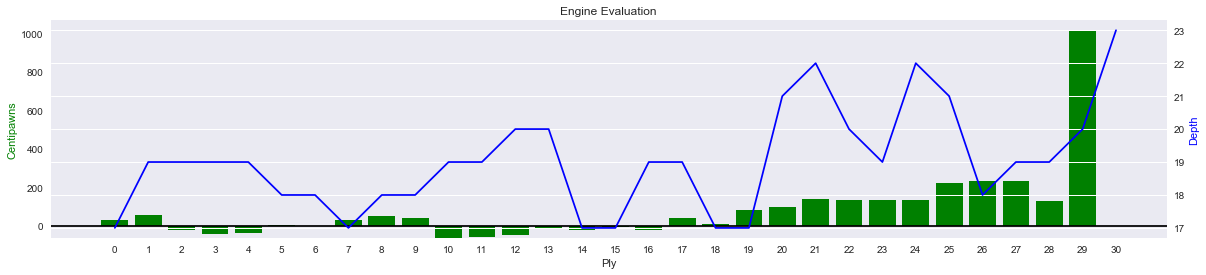

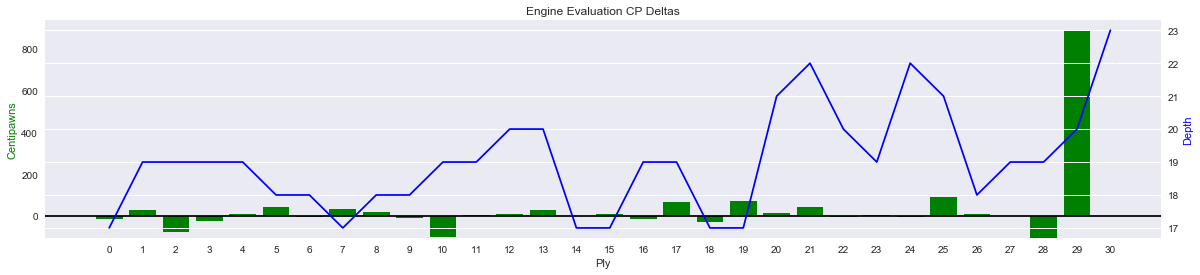

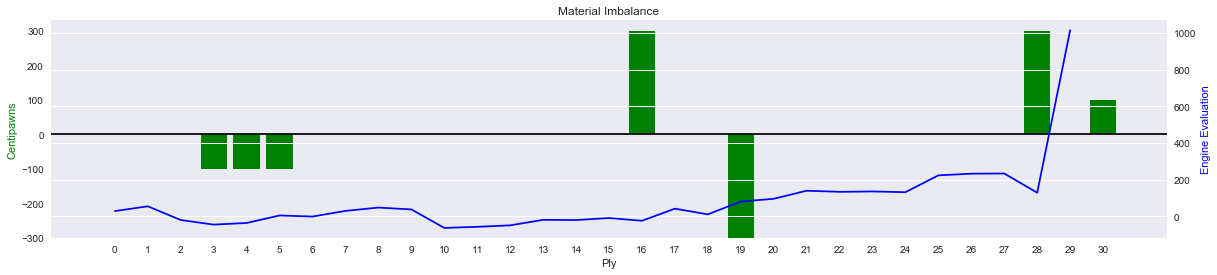

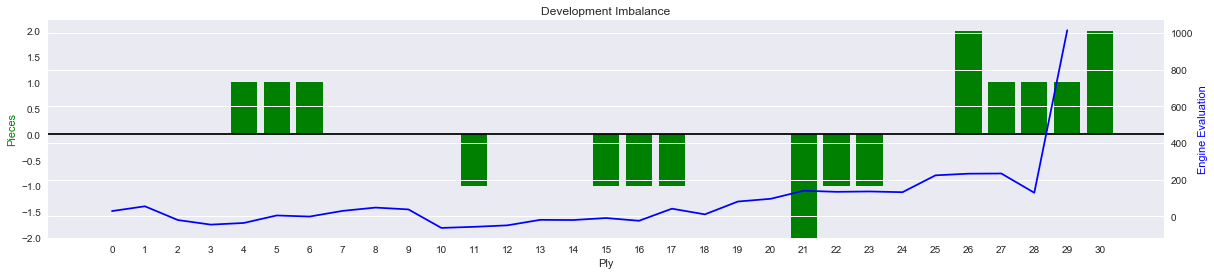

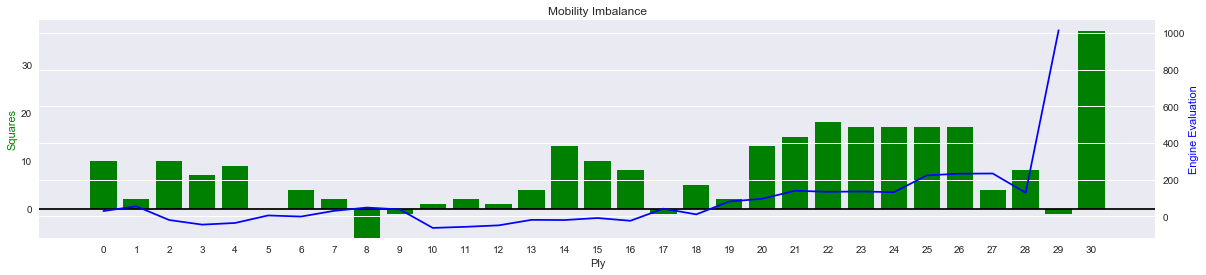

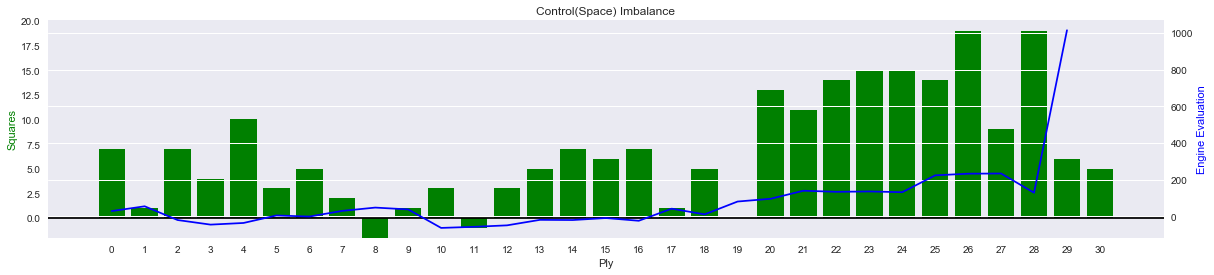

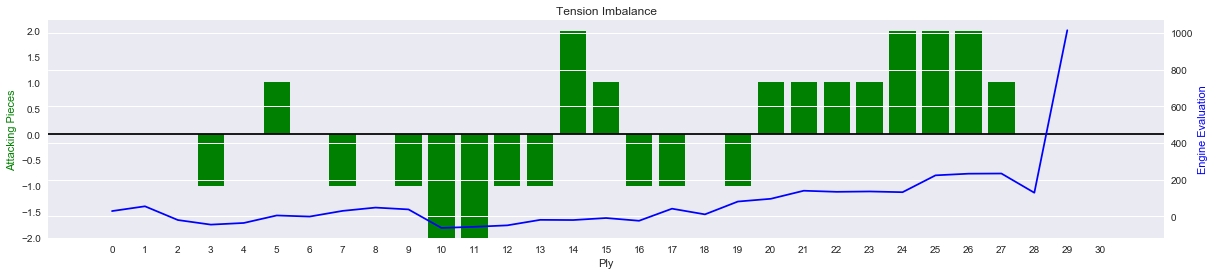

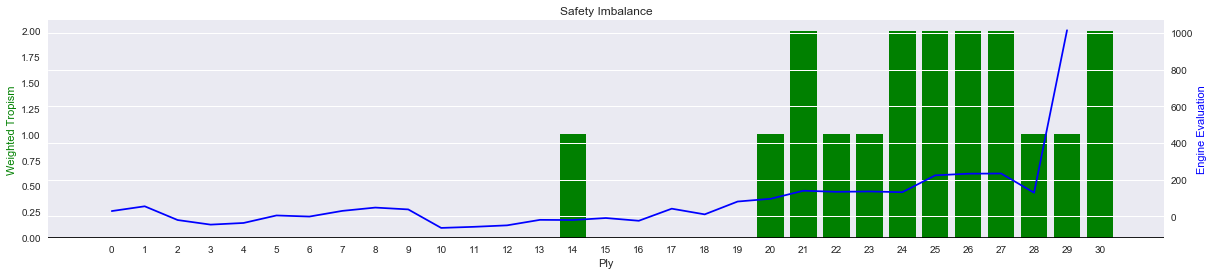

In [37]:
# Generate evaluation profile bar plots by ply
y = gamedata['CP']
z = gamedata['Depth']
x = gamedata['Ply']

frequency = int(round(max(x)/50,0)) # If the game has so many moves that the labels would overlap, change frequency

plt.figure(figsize=(20,4))
plt.ylabel ('Centipawns', color = 'green')
plt.bar (x,y,color = 'green')
plt.xticks (x[::frequency])
plt.xlabel ('Ply')
plt.axhline(0, color='black')
plt.grid()
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Depth', color = 'blue')
plt.title('Engine Evaluation')
plt.show()

y = gamedata['CP Delta']
z = gamedata['Depth']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Centipawns', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Engine Evaluation CP Deltas')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Depth', color = 'blue')
plt.show()

y = gamedata['Material']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Centipawns', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Material Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Development']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Pieces', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Development Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Mobility']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Squares', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Mobility Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Control']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Squares', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Control(Space) Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Tension']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Attacking Pieces', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Tension Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()

y = gamedata['Safety']
z = gamedata['CP']
plt.figure(figsize=(20,4))
plt.bar (x,y,color = 'green')
plt.ylabel ('Weighted Tropism', color = 'green')
plt.xlabel ('Ply')
plt.xticks (x[::frequency])
plt.title('Safety Imbalance')
plt.grid()
plt.axhline(0, color='black')
plt.twinx()
plt.plot (x,z, color = 'blue')
plt.ylabel('Engine Evaluation', color = 'blue')
plt.show()


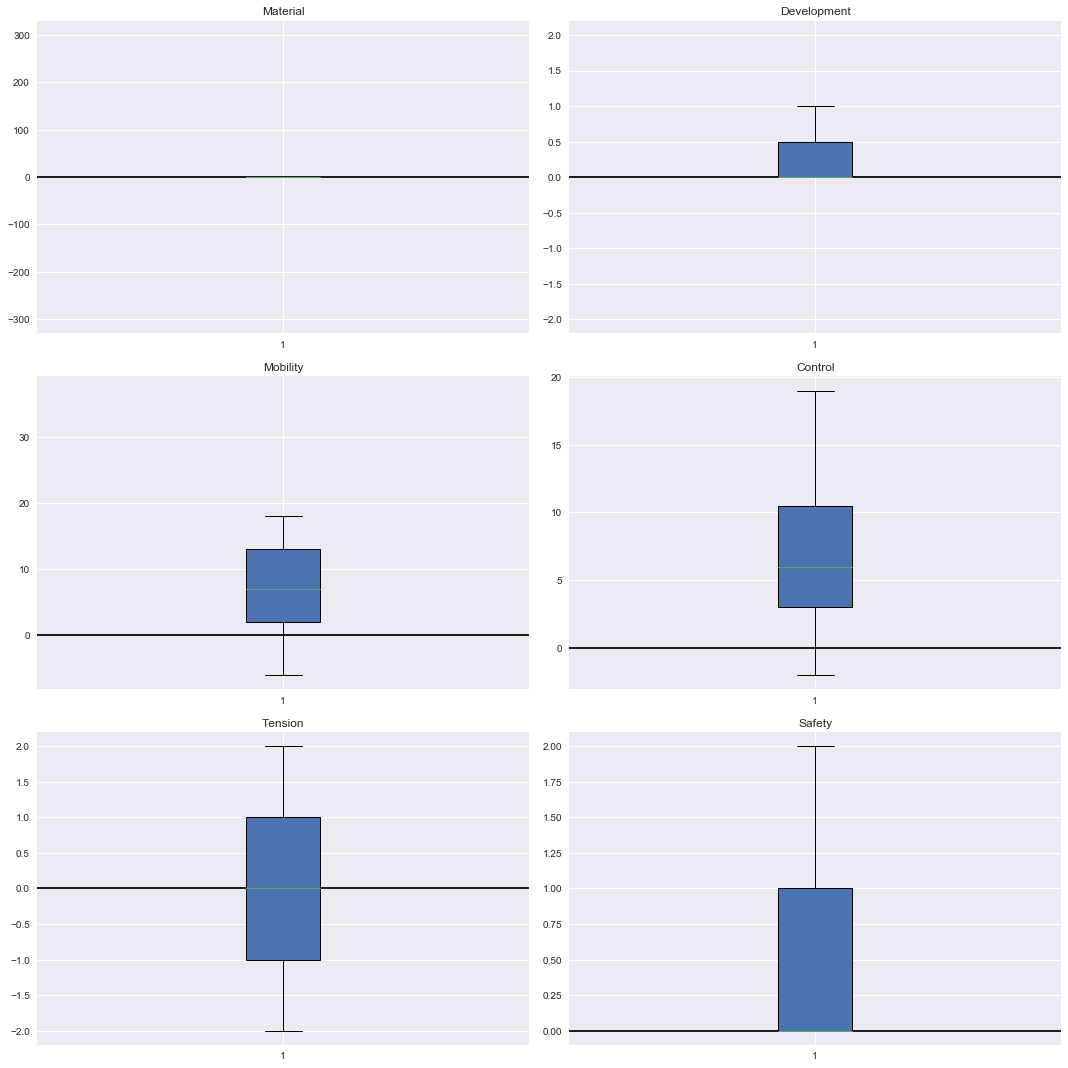

In [38]:
# Now generate boxplots to show dominance over entire game

fig,((matbox,devbox),(mobbox,conbox),(tenbox,safbox)) = plt.subplots(nrows=3, ncols=2, figsize =(15,15))
matbox.boxplot(gamedata['Material'], patch_artist=True)
matbox.set_title('Material')
matbox.axhline(0, color='black')
devbox.boxplot(gamedata['Development'], patch_artist=True)
devbox.set_title('Development')
devbox.axhline(0, color='black')
mobbox.boxplot(gamedata['Mobility'], patch_artist=True)
mobbox.set_title('Mobility')
mobbox.axhline(0, color='black')
conbox.boxplot(gamedata['Control'], patch_artist=True)
conbox.set_title('Control')
conbox.axhline(0, color='black')
tenbox.boxplot(gamedata['Tension'], patch_artist=True)
tenbox.set_title('Tension')
tenbox.axhline(0, color='black')
safbox.boxplot(gamedata['Safety'], patch_artist=True)
safbox.set_title('Safety')
safbox.axhline(0, color='black')
plt.tight_layout()
plt.show()


In [39]:
# Identify innacuracies, mistakes, and blunders and store in a new dataframe

errors = pd.DataFrame (columns =['Ply', 'Side' ,'Move', 'CP', 'CP Delta', 'Type', 'Suggested', 'Depth'])

for index,row in gamedata.iterrows():
    if row['Side'] == "B":
        if row['CP Delta'] > blunder:
            type = 'Blunder'
        elif row['CP Delta'] > mistake:
            type = 'Mistake'
        elif row['CP Delta'] > inaccuracy:
            type = 'Inaccuracy'
        if row['CP Delta'] > inaccuracy:
            movedata = pd.DataFrame([(row['Ply'], row['Side'], row['Move'], row['CP'], row['CP Delta'],\
                                      type, row['Suggested'], row['Depth'])], columns =['Ply', 'Side', \
                                      'Move', 'CP','CP Delta', 'Type','Suggested','Depth'])

            errors = errors.append(movedata, ignore_index=True)
            
    if row['Side'] == "W":
        if row['CP Delta'] < -blunder:
            type = 'Blunder'
        elif row['CP Delta'] < -mistake:
            type = 'Mistake'
        elif row['CP Delta'] < -inaccuracy:
            type = 'Inaccuracy'
        if row['CP Delta'] < -inaccuracy:
            movedata = pd.DataFrame([(row['Ply'], row['Side'], row['Move'], row['CP'], row['CP Delta'],\
                                      type, row['Suggested'], row['Depth'])], columns =['Ply', 'Side', \
                                      'Move', 'CP','CP Delta', 'Type','Suggested', 'Depth'])

            errors = errors.append(movedata, ignore_index=True)                     

            
#summary of inaccuracies, mistakes and blunders in errors dataframe
pd.options.display.max_rows=1000
errors                                



        


,Ply,Side,Move,CP,CP Delta,Type,Suggested,Depth
0,2.0,W,d4,-21.0,-75.0,Inaccuracy,exd5,19.0
1,5.0,B,e5,4.0,41.0,Inaccuracy,Nf6,18.0
2,7.0,B,Bf5,29.0,31.0,Inaccuracy,exd4,17.0
3,10.0,W,d5,-64.0,-101.0,Mistake,h4,19.0
4,17.0,B,fxg6,41.0,66.0,Inaccuracy,hxg6,19.0
5,18.0,W,Bg5,10.0,-31.0,Inaccuracy,Be3,17.0
6,19.0,B,Bxg3,80.0,70.0,Inaccuracy,Nbd7,17.0
7,21.0,B,O-O,139.0,44.0,Inaccuracy,Qxd5,22.0
8,25.0,B,Re8,223.0,92.0,Mistake,Qd6,21.0
9,28.0,W,Bxf6,128.0,-105.0,Mistake,Bf4,19.0


In [40]:
# Calculate play quality based on % of moves that are NOT innacuracies, mistakes, or blunders by deducting points
# for each and define quality as a precentage based on max possible points.

# Define scoring system as decuctions out of a total possible 10 points per move
# This could be refined further in the future to skip opening moves and treat forced moves differently
isc = -2
msc = -5
bsc = -10
whiteinaccuracies = 0
whitemistakes = 0
whiteblunders = 0
blackinaccuracies = 0
blackmistakes = 0
blackblunders = 0

totalwhite = len(gamedata[gamedata['Side']== "W"])*10
totalwhitescore = totalwhite
totalblack = len(gamedata[gamedata['Side']== "B"])*10
totalblackscore = totalblack


for index,row in errors.iterrows():
    if row['Side'] == "B":
        if row['Type'] == "Inaccuracy":
            totalblackscore += isc
            blackinaccuracies +=1
        elif row['Type'] == "Mistake":
            totalblackscore += msc
            blackmistakes +=1
        elif row['Type'] == "Blunder":
            totalblackscore += bsc
            blackblunders +=1
    if row['Side'] == "W":
        if row['Type'] == "Inaccuracy":
            totalwhitescore += isc
            whiteinaccuracies +=1
        elif row['Type'] == "Mistake":
            totalwhitescore += msc
            whitemistakes +=1
        elif row['Type'] == "Blunder":
            totalwhitescore += bsc
            whiteblunders +=1
        
            
whitequality = float(totalwhitescore)/float(totalwhite)
blackquality = float(totalblackscore)/float(totalblack)            

print "Event:",game.headers["Event"]
print "Site:",game.headers["Site"]
print "Date:",game.headers["Date"]
print "Round:",game.headers["Round"]
print "White:",game.headers["White"]
print "Black:",game.headers["Black"]
print "Result:",game.headers["Result"]
print "Quality of White Play:",round(whitequality*100,0),"%"
print "White made",whiteinaccuracies,"inaccuracies,",whitemistakes,"mistakes, and", whiteblunders,"blunders."
print "Quality of Black Play:",round(blackquality*100,0),"%"
print "Black made",blackinaccuracies,"inaccuracies,",blackmistakes,"mistakes, and", blackblunders,"blunders."


pgnin.close()

Event: Rated game
Site: https://lichess.org/xULYFfD1
Date: 2017.04.07
Round: ?
White: mattchessic
Black: Herrera19
Result: 1-0
Quality of White Play: 91.0 %
White made 2 inaccuracies, 2 mistakes, and 0 blunders.
Quality of Black Play: 83.0 %
Black made 5 inaccuracies, 1 mistakes, and 1 blunders.


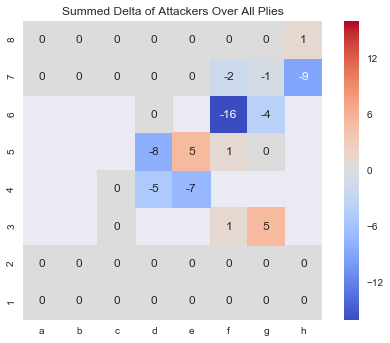

In [41]:
# Create game tension heatmaps for each position and overall game
# Sum of white attackers less black attackers for each occupied square that is under attack

with io.open(path+pgnfile,encoding="utf-8-sig)") as pgnin:
    game = chess.pgn.read_game(pgnin)

board = chess.Board()
node = game

#establish a dataframe to store my evaluations
attackedlist = pd.DataFrame(index=range(0,64), columns=range(0,ply))
attackedmap = pd.DataFrame (index = [8,7,6,5,4,3,2,1],columns =[1,2,3,4,5,6,7,8])

# loop through the game to count for each occupied square for each ply
ply = 0
while not node.is_end():
    next_node = node.variations[0]
    node = next_node
    board.push(next_node.move)
    
    for spacesquare in range(64):
        attackers = 0 
        if board.piece_at(spacesquare):
            if board.piece_at(spacesquare).color == chess.BLACK:
                if board.is_attacked_by(chess.WHITE, spacesquare):
                        attackers = len(board.attackers(chess.WHITE, spacesquare))-\
                                    len(board.attackers(chess.BLACK, spacesquare))
            if board.piece_at(spacesquare).color==chess.WHITE:
                if board.is_attacked_by(chess.BLACK, spacesquare):
                        attackers = len(board.attackers(chess.WHITE, spacesquare))-\
                                    len(board.attackers(chess.BLACK, spacesquare))      
            attackedlist.set_value(spacesquare,ply,attackers)        
    ply += 1

plytotal = ply

attackedlist['sum'] = attackedlist.sum(axis=1)

ply = 0
for ply in range (plytotal):
    for spacesquare in range (64):
        
        attackedmap.set_value(chess.square_rank(spacesquare)+1, \
                              chess.square_file(spacesquare)+1,attackedlist.iloc[spacesquare, ply+1])

attackedmap = attackedmap.astype(float)            
sns.heatmap(attackedmap, cmap="coolwarm", annot = True, fmt = '.0f', square = True, \
xticklabels = ['a','b','c','d','e','f','g','h'])
plt.title("Summed Delta of Attackers Over All Plies")
plt.show()
    
pgnin.close()